In [1]:
import pandas as pd
# import glob
# from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
import joblib
from tabulate import tabulate

# data science libraries
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold 
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
# from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier

# custom module
from package import my_modules

In [2]:
rng = np.random.RandomState(42)

In [3]:
# read the cleaned splits
X_train_cleaned, X_test_cleaned, X_holdout_cleaned,y_train, y_test, y_holdout = joblib.load("../out_files/cleaned_splits/split_data_cleaned.joblib")

In [4]:
# Define the scoring metric (e.g., F2 score)
ftwo_score = make_scorer(fbeta_score, beta=2)

# list of columns that are not medians
icu_cols = my_modules.get_colnames_with_prefix(X_train_cleaned,'ICUType_')
non_stat_cols = ['Age', 'Height','Weight'] + icu_cols

Training logistic_regression model...


Pipeline(steps=[('imputer', KNNImputer()), ('scaler', StandardScaler()),
                ('classifier',
                 LogisticRegression(class_weight='balanced',
                                    random_state=RandomState(MT19937) at 0x7135153A9A40,
                                    solver='liblinear'))])

Calculating PR AUC...
Model PR AUC: 0.50


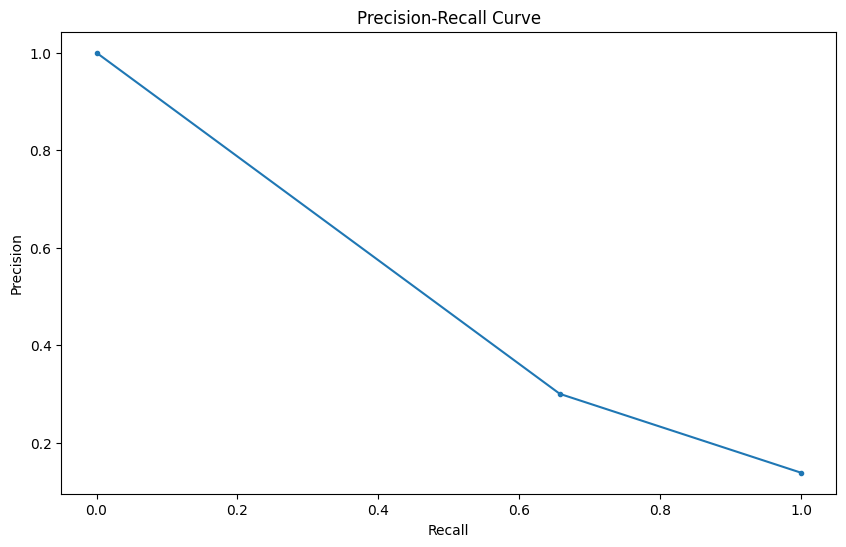

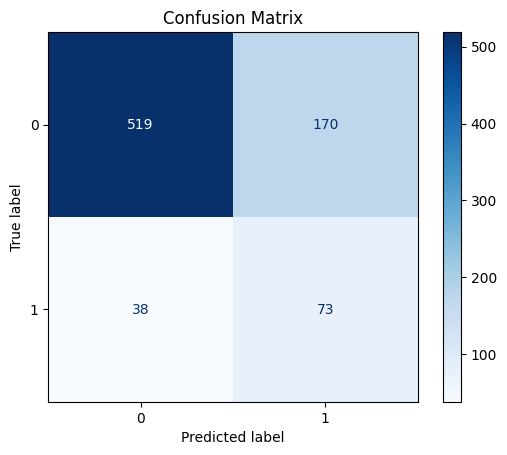

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.75      0.83       689
           1       0.30      0.66      0.41       111

    accuracy                           0.74       800
   macro avg       0.62      0.71      0.62       800
weighted avg       0.84      0.74      0.77       800



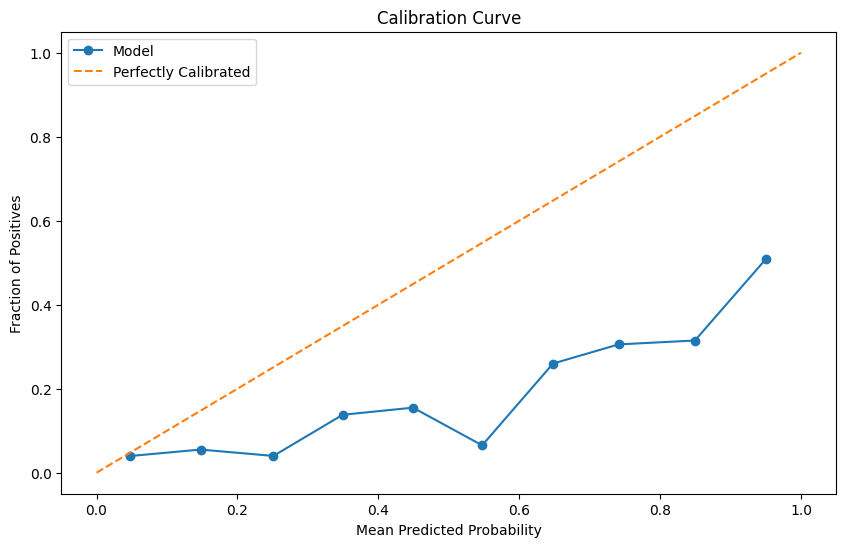

logistic_regression model does not have feature importances.
Training random_forest model...


Pipeline(steps=[('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=RandomState(MT19937) at 0x7135153A9A40))])

Calculating PR AUC...
Model PR AUC: 0.51


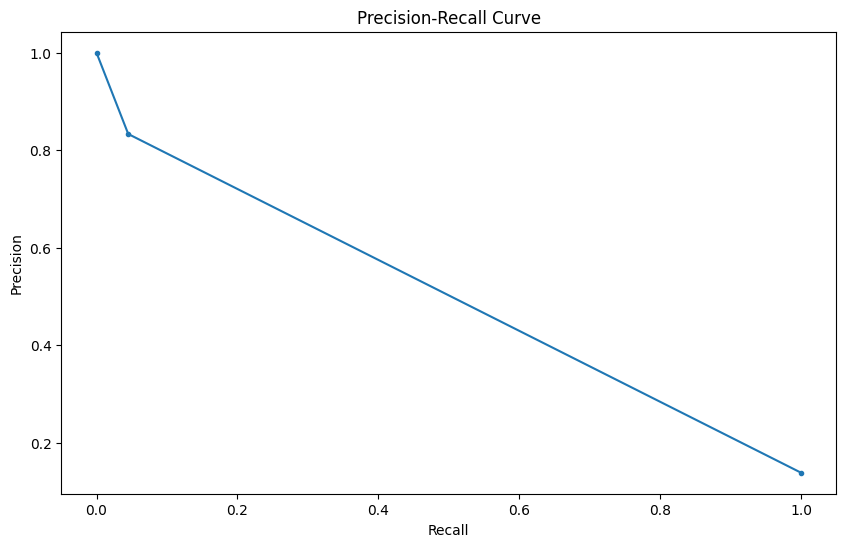

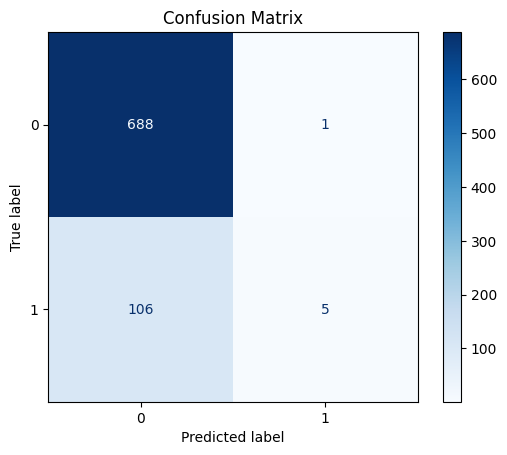

Classification Report:
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       689
           1       0.83      0.05      0.09       111

    accuracy                           0.87       800
   macro avg       0.85      0.52      0.51       800
weighted avg       0.86      0.87      0.81       800



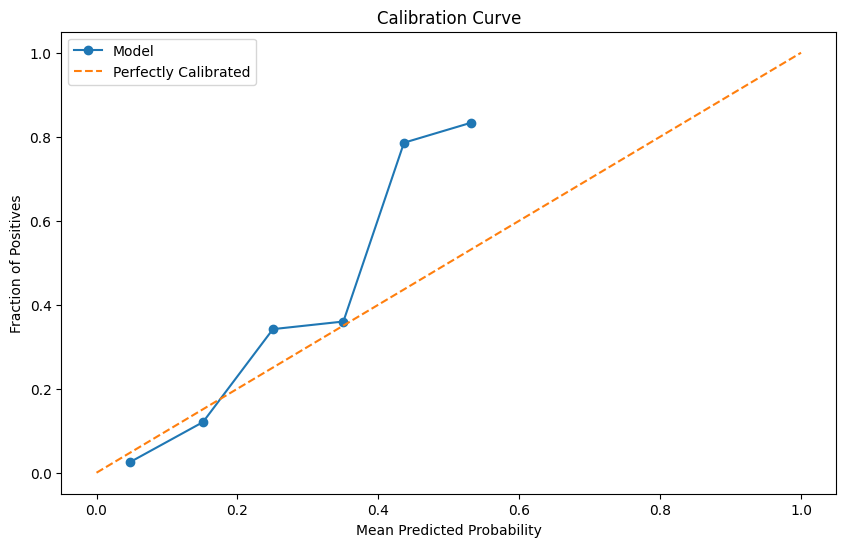

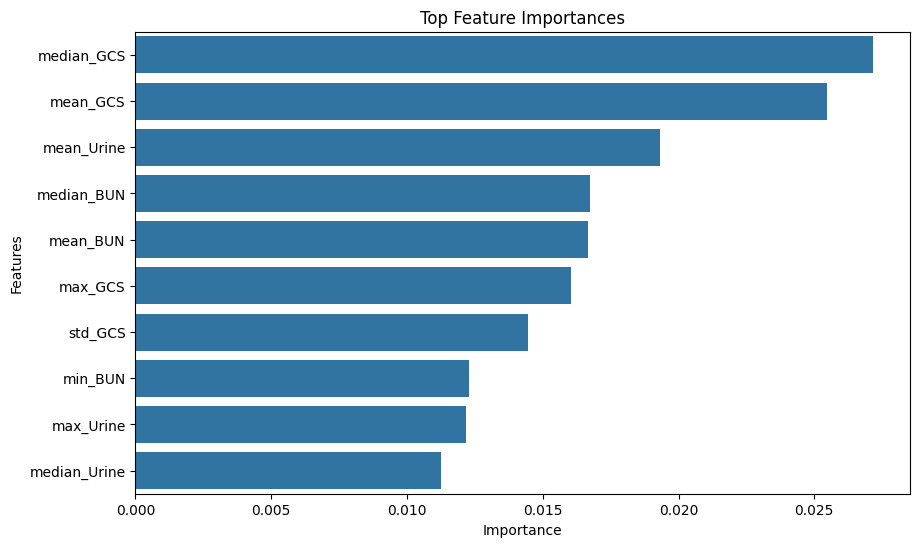

Training xgboost model...


Pipeline(steps=[('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

Calculating PR AUC...
Model PR AUC: 0.56


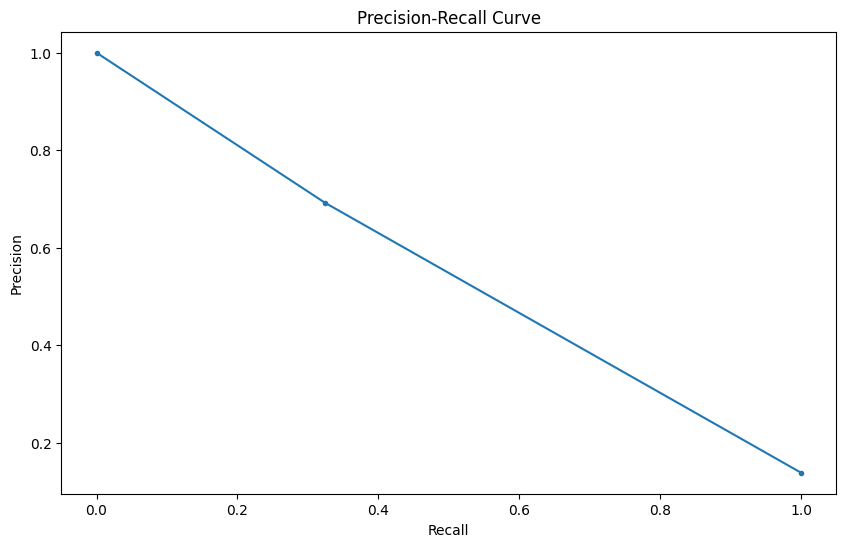

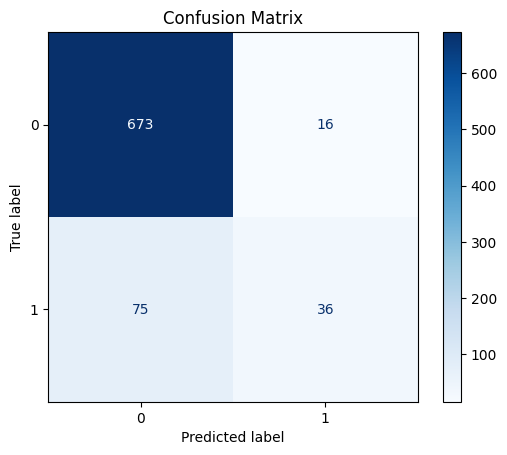

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.98      0.94       689
           1       0.69      0.32      0.44       111

    accuracy                           0.89       800
   macro avg       0.80      0.65      0.69       800
weighted avg       0.87      0.89      0.87       800



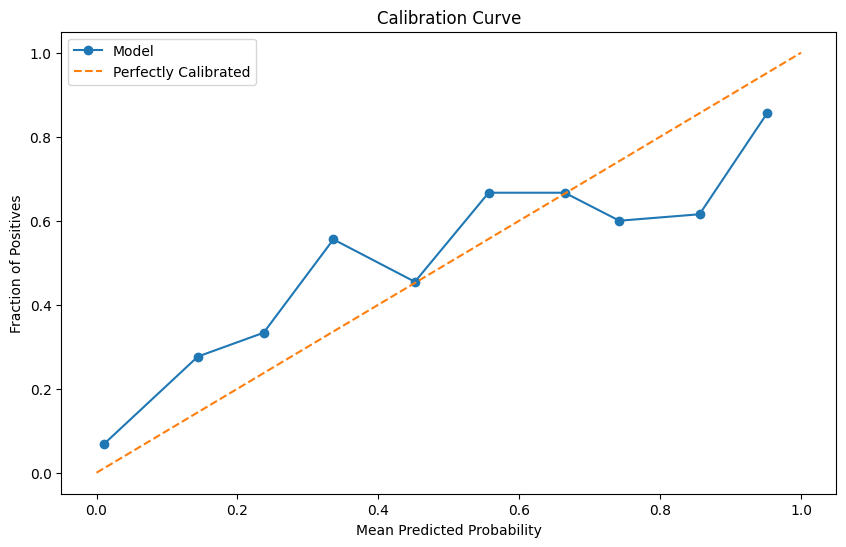

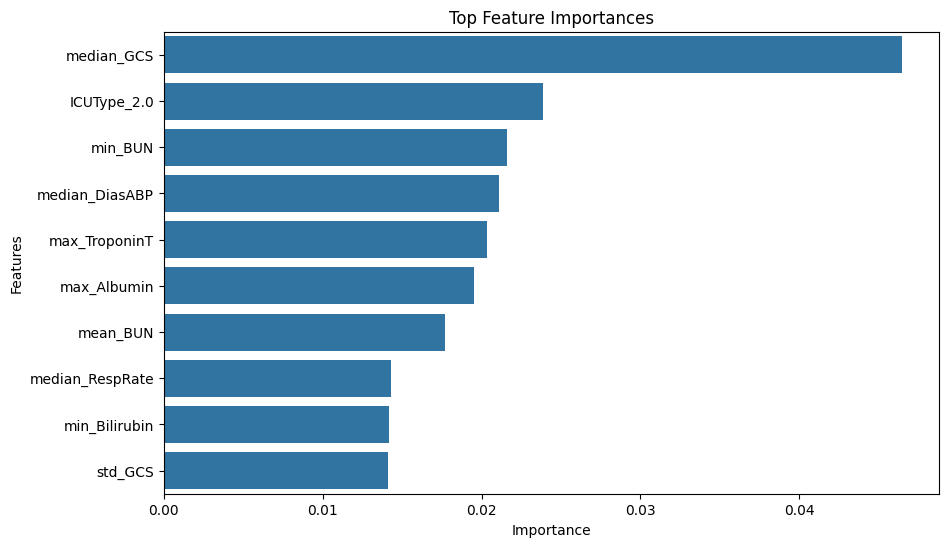

In [5]:
# # preprocessing - scaling only for columns that don't contain summary statistic

# preprocessor = ColumnTransformer(
#                 transformers=[('raw',StandardScaler(),non_stat_cols)],
#                 remainder='passthrough',
#                 force_int_remainder_cols=False

# )
# run logistic regression & random forest
model_factory = {
    'logistic_regression': Pipeline([
        # ('preprocessor', preprocessor),
        ('imputer', KNNImputer(n_neighbors=5)),
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(solver='liblinear', random_state=rng, class_weight='balanced'))
    ]),
    'random_forest': Pipeline([
        # ('imputer', KNNImputer(n_neighbors=5)),
        # ('scaler', StandardScaler()),
        ('classifier', RandomForestClassifier(random_state=rng, class_weight='balanced')) 
    ]),
    'xgboost': Pipeline([
        # ('imputer', KNNImputer(n_neighbors=5)),
        # ('scaler', StandardScaler()),
        ('classifier', XGBClassifier(random_state=rng, scorer= ftwo_score))
    ])
}


for model_name, model in model_factory.items():
    print(f"Training {model_name} model...")
    model.fit(X_train_cleaned, y_train)
    my_modules.evaluate_model(model, X_test_cleaned, y_test)
    # plot feature importances
    if hasattr(model.named_steps['classifier'], 'feature_importances_'):
        feature_importances = my_modules.get_feature_importances(model.named_steps['classifier'], X_train_cleaned, y_train)
        n_features_to_plot = min(10, len(feature_importances))
        my_modules.plot_feature_importances(feature_importances, n=n_features_to_plot)
    else:
        print(f"{model_name} model does not have feature importances.")   
        
        
        

In [ ]:


# # Lets get baseline logistic regression model
# logreg_model = Pipeline([
#     ('imputer', KNNImputer(n_neighbors=5)),
#     ('scaler', StandardScaler()),
#     ('classifier', LogisticRegression(solver='liblinear', random_state=rng, class_weight='balanced'))
# ])
# logreg_model.fit(X_train_cleaned, y_train)
# y_pred = logreg_model.predict(X_test_cleaned)

# # evaluate the logistic regression model
# # create PR AUC curve

# evaluate_model(logreg_model, X_test_cleaned, y_test)



In [ ]:
# # random forest model
# rf_model = Pipeline([
#     # ('imputer', KNNImputer(n_neighbors=5)),
#     # ('scaler', StandardScaler()),
#     ('classifier', RandomForestClassifier(random_state=rng, class_weight='balanced'))
# ])
# # fit model
# rf_model.fit(X_train_cleaned, y_train)
# # evaluate model
# evaluate_model(rf_model, X_test_cleaned, y_test)
# # get feature importances
# rf_classifier = rf_model.named_steps['classifier']  # Extract the RandomForestClassifier from the pipeline
# feature_importances = get_feature_importances(rf_classifier, X_train_cleaned, y_train)
# # plot feature importances
# plot_feature_importances(feature_importances, n=10)

In [ ]:
# # random forest model
# rf_model = Pipeline([
#     # ('imputer', KNNImputer(n_neighbors=5)),
#     # ('scaler', StandardScaler()),
#     ('classifier', RandomForestClassifier(random_state=rng, class_weight='balanced'))
# ])

# skf = get_stratified_kfold(X_train_cleaned, y_train, n_splits=5, random_state=rng)
# # fit random forest model on skf folds
# for fold, (train_index, test_index) in enumerate(skf):
#     print(f"Fold {fold+1}")
#     X_train_fold, X_test_fold = X_train_cleaned.iloc[train_index], X_train_cleaned.iloc[test_index]
#     y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
    
#     rf_model.fit(X_train_fold, y_train_fold)
#     evaluate_model(rf_model, X_test_fold, y_test_fold)
#     # plot feature importances
#     # Extract the RandomForestClassifier from the pipeline after fitting
#     rf_classifier_fold = rf_model.named_steps['classifier']
#     feature_importances = get_feature_importances(rf_classifier_fold, X_train_fold, y_train_fold)
#     # Ensure that the feature_importances DataFrame is not empty
#     if not feature_importances.empty:
#         # Ensure that the number of features to plot does not exceed the available features
#         n_features_to_plot = min(10, len(feature_importances))
#         plot_feature_importances(feature_importances, n=n_features_to_plot)
#     else:
#         print(f"No feature importances available for Fold {fold+1}. Skipping plot.")

# # # compute cross-validation metrics
# # cv_scores = cross_val_score(rf_model, X_train_cleaned, y_train, cv=skf, scoring=ftwo_score)
# # print(f"Cross-validation F1 scores: {cv_scores}")
# # print(f"Mean cross-validation F1 score: {np.mean(cv_scores):.2f}")


In [ ]:
# from sklearn.model_selection import cross_val_score



# # Recreate the Stratified K-Folds cross-validator
# skf = get_stratified_kfold(X_train_cleaned, y_train, n_splits=5)

# # Perform cross-validation
# cv_scores = cross_val_score(rf_model, X_train_cleaned, y_train, cv=skf, scoring=ftwo_score)

# # Print the cross-validation scores and their mean
# print(f"Cross-validation F2 scores: {cv_scores}")
# print(f"Mean cross-validation F2 score: {np.mean(cv_scores):.2f}")

In [ ]:
# # run logistic regression, random forest, gradient boosting, xgboost, decision tree on stratified k folds
# model_factory = {
#     'logistic_regression': Pipeline([
#         ('imputer', KNNImputer(n_neighbors=5)),
#         ('scaler', StandardScaler()),
#         ('classifier', LogisticRegression(solver='liblinear', random_state=rng, class_weight='balanced'))
#     ]),
#     'random_forest': Pipeline([
#         # ('imputer', KNNImputer(n_neighbors=5)),
#         # ('scaler', StandardScaler()),
#         ('classifier', RandomForestClassifier(random_state=rng, class_weight='balanced'))
#     ]),
#     # 'gradient_boosting': Pipeline([
#     #     ('imputer', KNNImputer(n_neighbors=5)),  # Ensure missing values are imputed
#     #     ('scaler', StandardScaler()),
#     #     ('classifier', GradientBoostingClassifier(random_state=rng))
#     # ]),
#     'xgboost': Pipeline([
#         # ('imputer', KNNImputer(n_neighbors=5)),
#         # ('scaler', StandardScaler()),
#         ('classifier', XGBClassifier(random_state=rng, scorer= ftwo_score))
#     ])
# }

# # skf = get_stratified_kfold(X_train_cleaned, y_train, n_splits=5)
# # fit random forest model on skf folds
# for model_name, model in model_factory.items():
#     print(f"Training {model_name} model...")
#     skf = get_stratified_kfold(X_train_cleaned, y_train, n_splits=5)
#     for fold, (train_index, test_index) in enumerate(skf):
#         print(f"Fold {fold+1}")
#         X_train_fold, X_test_fold = X_train_cleaned.iloc[train_index], X_train_cleaned.iloc[test_index]
#         y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
        
#         model.fit(X_train_fold, y_train_fold)
#         evaluate_model(model, X_test_fold, y_test_fold)
#         # plot feature importances
#         if hasattr(model.named_steps['classifier'], 'feature_importances_'):
#             feature_importances = get_feature_importances(model.named_steps['classifier'], X_train_fold, y_train_fold)
#             n_features_to_plot = min(10, len(feature_importances))
#             plot_feature_importances(feature_importances, n=n_features_to_plot)
#         else:
#             print(f"{model_name} model does not have feature importances.")

-The PR AUC (Area Under the Precision-Recall Curve) is not curved, but has step-like appearance

min_ALP            0
min_ALT            0
min_AST            0
min_Albumin        0
min_BUN            0
min_Bilirubin      0
min_Cholesterol    0
min_Creatinine     0
min_DiasABP        0
min_FiO2           0
min_GCS            0
min_Glucose        0
min_HCO3           0
min_HCT            0
min_HR             0
min_ICUType        0
min_K              0
min_Lactate        0
min_MAP            0
min_Mg             0
dtype: int64

<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='Mutual Information', ylabel='None'>

Text(0.5, 1.0, 'Top 10 Mutual Information Scores')

Text(0.5, 0, 'Mutual Information')

Text(0, 0.5, 'Features')

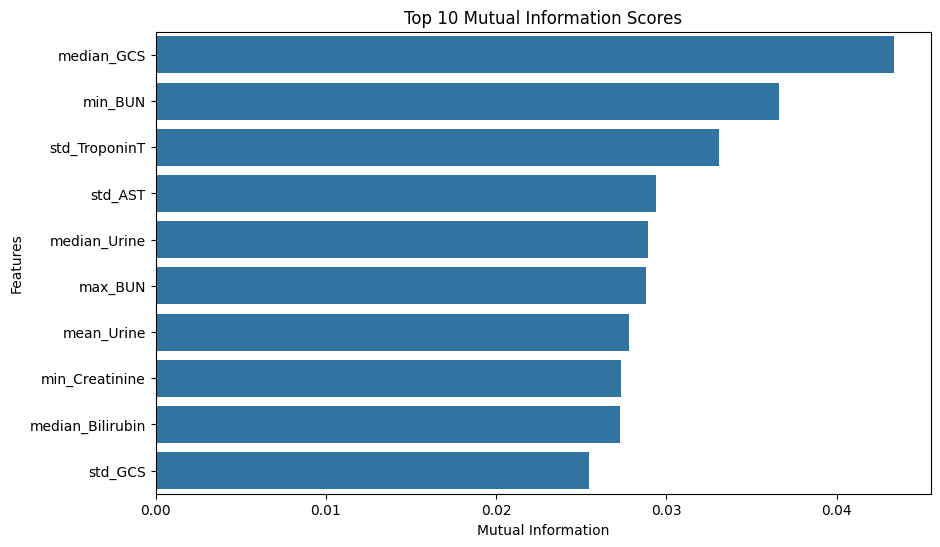

In [ ]:
# calculate mutual information scores
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest


# create non-binary features dataset
non_binary_features = [
    c for c in X_train_cleaned.columns if len(set(X_train_cleaned[c])) > 2]
non_binary_train = X_train_cleaned[non_binary_features]

# knn imputer
imputer = KNNImputer(n_neighbors=5)
# impute missing values
non_binary_train_imputed = imputer.fit_transform(non_binary_train)
# convert to DataFrame
non_binary_train_imputed = pd.DataFrame(non_binary_train_imputed, columns=non_binary_train.columns[:non_binary_train_imputed.shape[1]])
# check for missing values
non_binary_train_imputed.isnull().sum().sort_values(ascending=False).head(20)

# calculate mutual information scores
mi_scores = mutual_info_classif(non_binary_train_imputed, y_train, random_state=rng)



# create a DataFrame of mutual information scores
mi_scores_df = pd.DataFrame(mi_scores, index=non_binary_train_imputed.columns, columns=["Mutual Information"])
mi_scores_df.sort_values(by="Mutual Information", ascending=False, inplace=True)
# plot mutual information scores
plt.figure(figsize=(10, 6))
sns.barplot(x=mi_scores_df["Mutual Information"][:10], y=mi_scores_df.index[:10])
plt.title("Top 10 Mutual Information Scores")
plt.xlabel("Mutual Information")
plt.ylabel("Features")
plt.show()

